<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h2>Predicting Bee Colony Loss for US states</h2>
</div>

As observed in notebook 3 EDA, percent loss of bee colonies differs strongly across quarters and is affected by different features in different states.

Moreover, time series forecasting require the timestamps to be unique. This dataset however has the same daterange per state.

Therefore, a subset of data is taken for a given state to obtain unique timestamps and models are built per state.

**Recommended**: Run the full notebook first, results will be shown for 'Ohio'. A different state can be given as input.

At the end of the notebook, functions are available to compare outputs for different states at once for each model.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

**Runtime**: The whole notebook takes approximately 1 minute to run. This can be significantly increased if many states and/or features are chosen in the final code cell.

**ML models**: Functions to run the ML models are provided within the notebook for easy parameter adjustments.

In [1]:
import os
import sys
import warnings
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Local utilities
sys.path.append(os.path.abspath('../utils'))
from tinne_utils import (
    adf_test,
    create_quarterly_index,
    set_bee_style,
    subset_by_state
)

warnings.filterwarnings('ignore')

set_bee_style()

In [2]:
# set working directory
ITM_DIR = os.path.join(os.getcwd(), '../data/cleaned')

In [3]:
# read in data
bees = pd.read_csv(os.path.join(ITM_DIR, 'bees_clean_imputed.csv'))
bees = bees.drop('state_code', axis = 1)

In [4]:
bees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   state                      1436 non-null   object 
 1   latitude                   1436 non-null   float64
 2   longitude                  1436 non-null   float64
 3   quarter                    1436 non-null   int64  
 4   temperature_2m_mean        1436 non-null   float64
 5   temperature_2m_sum         1436 non-null   float64
 6   relative_humidity_2m_mean  1436 non-null   float64
 7   relative_humidity_2m_sum   1436 non-null   float64
 8   wind_speed_10m_max         1436 non-null   float64
 9   temperature_2m_max         1436 non-null   float64
 10  relative_humidity_2m_max   1436 non-null   float64
 11  temperature_2m_min         1436 non-null   float64
 12  relative_humidity_2m_min   1436 non-null   float64
 13  precipitation_hours_sum    1436 non-null   float

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Set State for Model Selection</h3>
</div>

A subset of data is taken for a given state to obtain unique timestamps. Forecasting models are built per state.

**Note**: The remaining data available per state is very limited. Hence the predictive power of the models will be small.

In [5]:
state = 'Ohio'
state_bees = subset_by_state(bees,state)
state_bees = create_quarterly_index(state_bees)

In [6]:
state_bees.shape

(32, 51)

In [7]:
state_bees.isna().sum().sum()

0

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Sanity Check</h3>
</div>

The data should be in chronological order and the timestamps should be equidistant in time series. 

The chronological order can be achieved by sorting the dataframe by the timestamps.

 Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp is taken. 

In [8]:
state_bees = state_bees.sort_values(by='date')

state_bees['delta'] = state_bees['date'] - state_bees['date'].shift(1)

state_bees[['date', 'delta']]

state_bees['delta'].value_counts()

delta
92 days    15
91 days    10
90 days     6
Name: count, dtype: int64

Quarter lengths may vary depending on month length and leap years.

The results confirm the time interval is one quarter (90-92 days).

In [9]:
# drop delta column
state_bees = state_bees.drop('delta', axis = 1)

<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Evaluation for Model Selection</h3>
</div>

Some time series models, assume that the underlying data is stationary. 

A time series is stationary if its key statistical properties do not change over time:

**Constant mean**

**Constant variance**

**Constant autocovariance (dependence between values at different lags stays the same)**

Stationarity is checked visually and statistically by the Augmented Dickey Fuller test

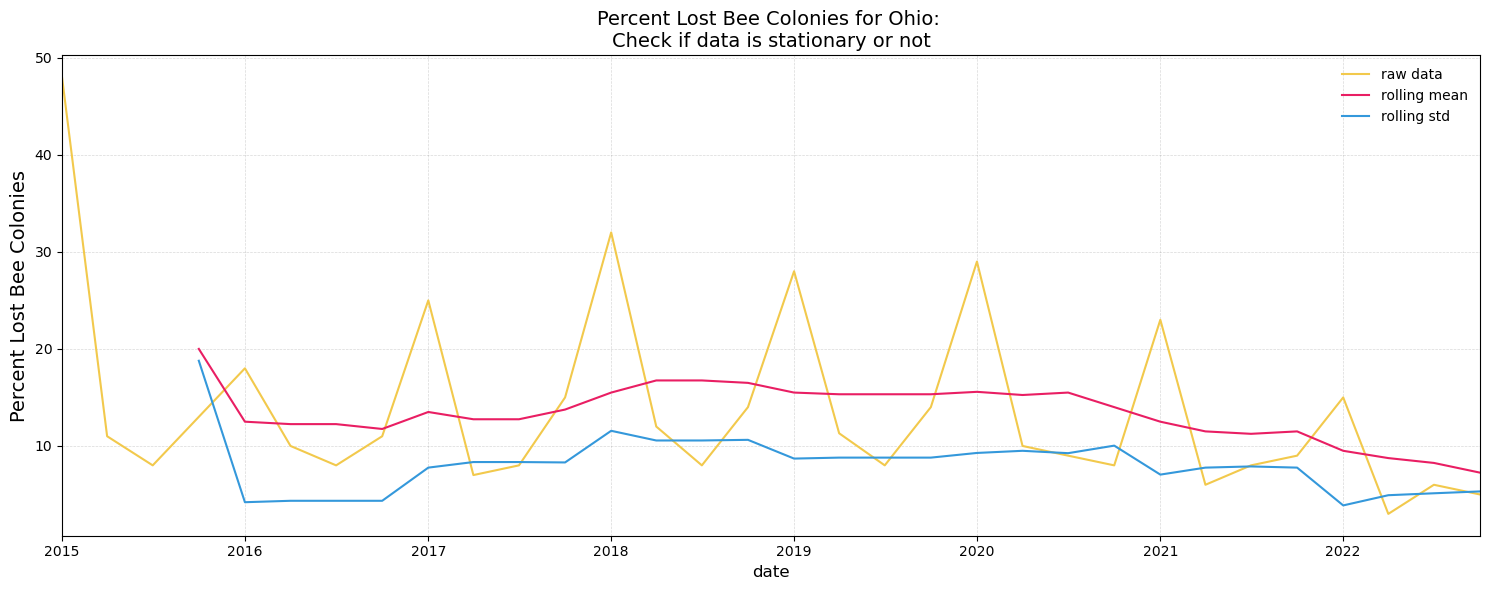

In [ ]:
# Visual check of the data
rolling_window = 4

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'], ax=ax, label='raw data')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).mean(), ax=ax, label='rolling mean')
sns.lineplot(x=state_bees['date'], y=state_bees['percent_lost'].rolling(rolling_window).std(), ax=ax,label='rolling std')

ax.set_title(f'Percent Lost Bee Colonies for {state}: \nCheck if data is stationary or not', fontsize=14)
ax.set_ylabel('Percent Lost Bee Colonies', fontsize=14)
ax.set_xlim([date(2015, 1, 1), date(2022, 10, 1)])

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [11]:
# Statitical test for stationarity
adf_test(state_bees['percent_lost'], state)

ADF test statistic       0.33909
p-value                 0.979069
# lags used                  4.0
# observations              27.0
critical value (1%)    -3.699608
critical value (5%)     -2.97643
critical value (10%)   -2.627601
stationary                 False
dtype: object

In [ ]:
# check how many states have stationary vs non-stationary ratio
stationarity_flags = []

for state in bees['state'].unique():
    series = bees[bees['state'] == state]['percent_lost']
    result = adf_test(series, state)
    stationarity_flags.append(result['stationary'])

flags_series = pd.Series(stationarity_flags)

true_ratio = flags_series.mean()  
false_ratio = 1 - true_ratio

print(f"Stationary (True) ratio: {true_ratio:.2f}")
print(f"Non-stationary (False) ratio: {false_ratio:.2f}")

Stationary (True) ratio: 0.60
Non-stationary (False) ratio: 0.40


Looks like 60% of the states percent lost data is stationary whereas 40% is not.

Time series decomposition may provide additional information.

**ARIMA on non-stationary data** is the bigger mistake—it ignores trends and changing patterns in your series, leading to misleading results.

**SARIMAX on already stationary data** is still a problem, but mostly because it adds needless complexity and noise rather than completely breaking the model.


<div style="background-color:#FCE205; padding:10px; border-radius:5px; color:black; font-weight:bold;">
    <h3>Time Series Decomposition</h3>
</div>

Time series are often a combination of trend, seasonality and noise.

- **Trend**: The overall increasing or decreasing value
- **Seasonality**: The repeating short-term cycle
- **Noise**: The random variation

Decomposition allows for for better understanding problems during analysis and forecasting

In [13]:
decomp = seasonal_decompose(state_bees['percent_lost'], period=4, model='additive', extrapolate_trend='freq')
state_bees[f"{'percent_lost'}_trend"] = decomp.trend
state_bees[f"{'percent_lost'}_seasonal"] = decomp.seasonal

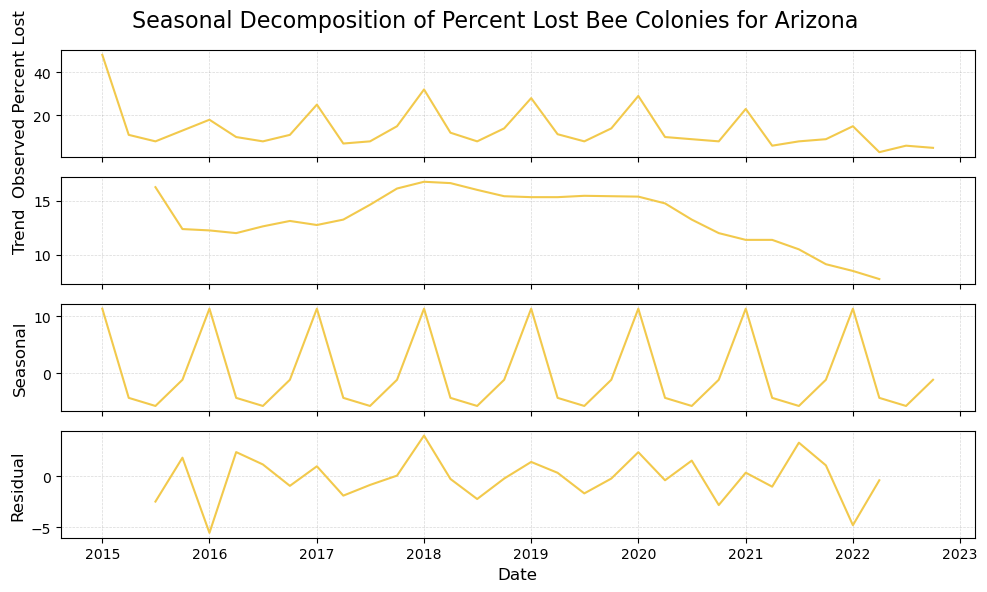

In [ ]:
state_bees = state_bees.sort_values('date')
state_bees_indexed = state_bees.set_index('date')

result = seasonal_decompose(state_bees_indexed['percent_lost'], model='additive', period=4)

fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

axs[0].plot(result.observed)
axs[0].set_ylabel('Observed Percent Lost')

axs[1].plot(result.trend, label='Trend')
axs[1].set_ylabel('Trend')

axs[2].plot(result.seasonal, label='Seasonal')
axs[2].set_ylabel('Seasonal')

axs[3].plot(result.resid, label='Residual')
axs[3].set_ylabel('Residual')
axs[3].set_xlabel('Date')

fig.suptitle(f'Seasonal Decomposition of Percent Lost Bee Colonies for {state}', fontsize=16)
plt.tight_layout()
plt.show()

<div
  style="
    background-color: #FCE205;
    padding: 10px 20px;      /* you can tweak horizontal padding */
    border-radius: 5px;
    color: black;
    font-weight: bold;
    height: 60px;            /* adjust as needed */
    line-height: 50px;
  "
>
  <h3 style="margin: 0;">Model Evaluation on Univariate Time series</h3>
</div>

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Univariate Time series
  </h5>
</div>


<div style="line-height:1.5">
Univariate time-series forecasting focuses on predicting future values of a single target variable using nothing but its own historical observations. 

By analyzing patterns such as trends, seasonality, and autocorrelation in past data, models like ARIMA, exponential smoothing, and modern machine-learning approaches can extrapolate into the future.
 </div>

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h8 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for univariate analysis
  </h8>
</div>

<div style="line-height:1.5">
In static forecasting our models only ever sees the “past” once and all future forecasts are extrapolations from that one fit.
 </div>

In [ ]:
def compare_univariate_static(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Compute and compare static multi-step forecasts on a univariate series.

    This function fits four different models:
      - Holt–Winters Exponential Smoothing
      - SARIMAX(1,1,1)x(1,1,1,seasonal_m)
      - Random Forest on lagged features
      - XGBoost on lagged features

    It then produces forecasts for the last `n_test` periods, plots the full
    actual series alongside all model forecasts (with a train/test split marker),
    and returns a summary DataFrame of RMSE and MAE for each model.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least `date_col` and `target_col`.
    date_col : str
        Name of the column in `df` to use as the datetime index.
    target_col : str
        Name of the target variable column to forecast.
    n_test : int, default=8
        Number of periods at the end of the series reserved for testing/forecasting.
    seasonal_m : int, default=4
        Seasonal period (e.g., 4 for quarterly data).
    lags : list of int, default=[1, 4]
        List of lag orders to use as features for the RandomForest and XGBoost models.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
          - 'Model': the forecasting model name
          - 'RMSE': root mean squared error over the test set
          - 'MAE': mean absolute error over the test set
    Displays a matplotlib plot showing:
          - the full actual series in yellow
          - each model’s n_test-step forecast in dashed lines with markers
          - a vertical line marking the train/test split
    
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)
    series = df[target_col]

    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

    # 1) Holt–Winters
    hwes = ExponentialSmoothing(
        train, trend='add', seasonal='add', seasonal_periods=seasonal_m
    ).fit()
    hwes_preds = pd.Series(hwes.forecast(n_test), index=test.index)

    # 2) SARIMAX
    sarimax = SARIMAX(
        train,
        order=(1,1,1),
        seasonal_order=(1,1,1,seasonal_m),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    sarimax_preds = pd.Series(
        sarimax.forecast(steps=n_test),
        index=test.index
    )

    # 3) lag features
    df_lag = pd.DataFrame({'y': series})
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    df_lag.dropna(inplace=True)

    ml_train = df_lag.iloc[:-n_test]
    ml_test  = df_lag.iloc[-n_test:]
    X_train, y_train = ml_train[[f'lag_{lag}' for lag in lags]], ml_train['y']
    X_test,  y_test  = ml_test [[f'lag_{lag}' for lag in lags]], ml_test['y']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = pd.Series(rf.predict(X_test), index=y_test.index)

    xgb = XGBRegressor(
        n_estimators=100, random_state=42,
        use_label_encoder=False, eval_metric='rmse'
    )
    xgb.fit(X_train, y_train)
    xgb_preds = pd.Series(xgb.predict(X_test), index=y_test.index)

    # metrics
    def compute_metrics(y_true, y_pred):
        mask = (~y_true.isna()) & (~y_pred.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            mean_absolute_error(y_true[mask], y_pred[mask])
        )

    models = ['HWES', 'SARIMAX', 'RF (lags)', 'XGB (lags)']
    preds_list = [hwes_preds, sarimax_preds, rf_preds, xgb_preds]
    metrics = pd.DataFrame([
        (m, *compute_metrics(test, p))
        for m,p in zip(models, preds_list)
    ], columns=['Model','RMSE','MAE'])

    # plot
    actual_full = series
    df_fore = pd.DataFrame({
        'HWES':       hwes_preds,
        'SARIMAX':    sarimax_preds,
        'RF (lags)':  rf_preds,
        'XGB (lags)': xgb_preds
    })
    df_plot = pd.concat([actual_full.rename('Actual'), df_fore], axis=1)

    fig, ax = plt.subplots(figsize=(12,6))
    df_plot['Actual'].plot(ax=ax, lw=2, label='Actual')
    df_plot[['HWES','SARIMAX','RF (lags)','XGB (lags)']].plot(
        ax=ax, linestyle='--', marker='o', alpha=0.8
    )
    split_date = train.index[-1]
    ax.axvline(split_date, linestyle=':', label='Train/Test split')
    ax.set_title(f'Full Actual Series + {n_test}-Step Forecasts by Model')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics

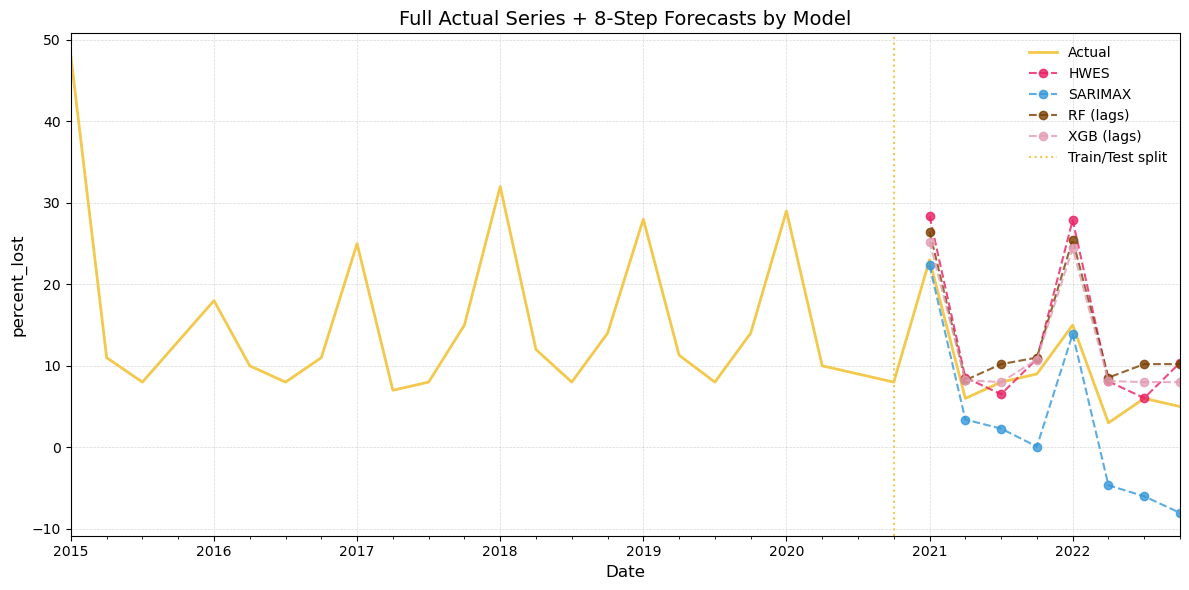

,Model,RMSE,MAE
0,HWES,5.716515,4.329202
1,SARIMAX,7.854118,6.462054
2,RF (lags),5.137397,4.420372
3,XGB (lags),4.199480,3.223584


In [16]:
compare_univariate_static(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk forward method univariate analysis
  </h7>
</div>

<div style="line-height:1.5">
Walk-forward (rolling) forecasting continuously retrains or updates the models as each new observation becomes available, ensuring that the predictions always leverage the most recent data and adapt to evolving patterns.

 </div>

In [ ]:
def evaluate_and_plot_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Perform one-step walk-forward forecasting with multiple models and plot cumulative errors.

    This routine fits four models in a rolling, one-step-ahead fashion on a univariate time series:
      1. Holt–Winters Exponential Smoothing
      2. SARIMAX(1,1,1)x(1,1,1,seasonal_m)
      3. Random Forest using specified lag features
      4. XGBoost using specified lag features

    For each step in the final `n_test` observations, it:
      - Re-fits the model on all available history
      - Forecasts the next point
      - Appends the true value to history

    After forecasting, it computes overall RMSE and MAE for each model, then
    plots the cumulative RMSE and MAE by quarter.

    Parameters
    ----------
    df : pd.DataFrame
        Input data containing at least a date column and a target column.
    date_col : str
        Name of the datetime column to use as the index.
    target_col : str
        Name of the series to forecast.
    n_test : int, default=8
        Number of last observations to reserve for walk-forward testing.
    seasonal_m : int, default=4
        Seasonal period (e.g. 4 for quarterly data).
    lags : list[int], default=[1, 4]
        Lag orders to generate features for the RF and XGB models.

    Returns
    -------
    pd.DataFrame
        A table of overall forecast accuracy:
          - Model: model name
          - RMSE: root mean squared error over all test steps
          - MAE: mean absolute error over all test steps
    Displays two side-by-side matplotlib plots:
        • Cumulative RMSE by quarter
        • Cumulative MAE by quarter

    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    series = df.set_index(date_col)[target_col].sort_index()

    train = series.iloc[:-n_test]
    test  = series.iloc[-n_test:]

    # 1) Generic walk-forward
    def walk_forward(model_builder, forecast_fn):
        history = train.copy()
        preds   = []
        for t in range(n_test):
            m  = model_builder(history)
            fc = forecast_fn(m, history)
            preds.append(fc)
            history.loc[test.index[t]] = test.iloc[t]
        return np.array(preds)

    # 2) Model builders & fns

    # Holt–Winters
    def build_hwes(y):
        return ExponentialSmoothing(
            y, trend='add', seasonal='add',
            seasonal_periods=seasonal_m
        ).fit()
    def f_hwes(m, h): 
        return m.forecast(1).iloc[0]

    # Fixed SARIMAX
    def build_sarimax(y):
        return SARIMAX(
            y,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal_m),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
    def f_sarimax(m, h):
        return m.forecast(steps=1).iloc[0]

    # Random Forest on lags
    def build_rf(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        return rf
    def f_rf(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    # XGBoost on lags
    def build_xgb(h):
        df_l = pd.DataFrame({'y': h})
        for lag in lags:
            df_l[f'lag_{lag}'] = df_l['y'].shift(lag)
        df_l.dropna(inplace=True)
        X = df_l[[f'lag_{lag}' for lag in lags]]
        y = df_l['y']
        xgb = XGBRegressor(
            n_estimators=100, random_state=42,
            use_label_encoder=False, eval_metric='rmse'
        )
        xgb.fit(X, y)
        return xgb
    def f_xgb(m, h):
        feat = {f'lag_{lag}': h.iloc[-lag] for lag in lags}
        return m.predict(pd.DataFrame([feat]))[0]

    # 3) Run forecasts
    preds_hwes    = walk_forward(build_hwes,    f_hwes)
    preds_sarimax = walk_forward(build_sarimax, f_sarimax)
    preds_rf      = walk_forward(build_rf,      f_rf)
    preds_xgb     = walk_forward(build_xgb,     f_xgb)

    # 4) Overall metrics
    metrics = pd.DataFrame({
        'Model': ['HWES', 'SARIMAX', 'RF (lags)', 'XGB (lags)'],
        'RMSE': [
            np.sqrt(mean_squared_error(test, preds_hwes)),
            np.sqrt(mean_squared_error(test, preds_sarimax)),
            np.sqrt(mean_squared_error(test, preds_rf)),
            np.sqrt(mean_squared_error(test, preds_xgb))
        ],
        'MAE': [
            mean_absolute_error(test, preds_hwes),
            mean_absolute_error(test, preds_sarimax),
            mean_absolute_error(test, preds_rf),
            mean_absolute_error(test, preds_xgb)
        ]
    })

    # 5) Build cumulative error DataFrames (indexed by quarter dates)
    idx = test.index
    cum_rmse = pd.DataFrame({
        'HWES':      [np.sqrt(mean_squared_error(test.values[:k], preds_hwes[:k])) for k in range(1, n_test+1)],
        'SARIMAX':   [np.sqrt(mean_squared_error(test.values[:k], preds_sarimax[:k])) for k in range(1, n_test+1)],
        'RF (lags)': [np.sqrt(mean_squared_error(test.values[:k], preds_rf[:k])) for k in range(1, n_test+1)],
        'XGB (lags)':[np.sqrt(mean_squared_error(test.values[:k], preds_xgb[:k])) for k in range(1, n_test+1)]
    }, index=idx)

    cum_mae = pd.DataFrame({
        'HWES':      [mean_absolute_error(test.values[:k], preds_hwes[:k]) for k in range(1, n_test+1)],
        'SARIMAX':   [mean_absolute_error(test.values[:k], preds_sarimax[:k]) for k in range(1, n_test+1)],
        'RF (lags)': [mean_absolute_error(test.values[:k], preds_rf[:k]) for k in range(1, n_test+1)],
        'XGB (lags)':[mean_absolute_error(test.values[:k], preds_xgb[:k]) for k in range(1, n_test+1)]
    }, index=idx)

    quarters = [f"{d.year}Q{d.quarter}" for d in idx]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
    
    cum_rmse.plot(ax=ax1, marker='o')
    ax1.set_title('Cumulative RMSE by Predicted Quarter')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RMSE')
    ax1.grid(True)
    ax1.set_xticks(idx)
    ax1.set_xticklabels(quarters, rotation=90, ha='center')
    
    cum_mae.plot(ax=ax2, marker='o')
    ax2.set_title('Cumulative MAE by Predicted Quarter')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MAE')
    ax2.grid(True)
    ax2.set_xticks(idx)
    ax2.set_xticklabels(quarters, rotation=90, ha='center')
    
    plt.tight_layout()
    plt.show()

    return metrics

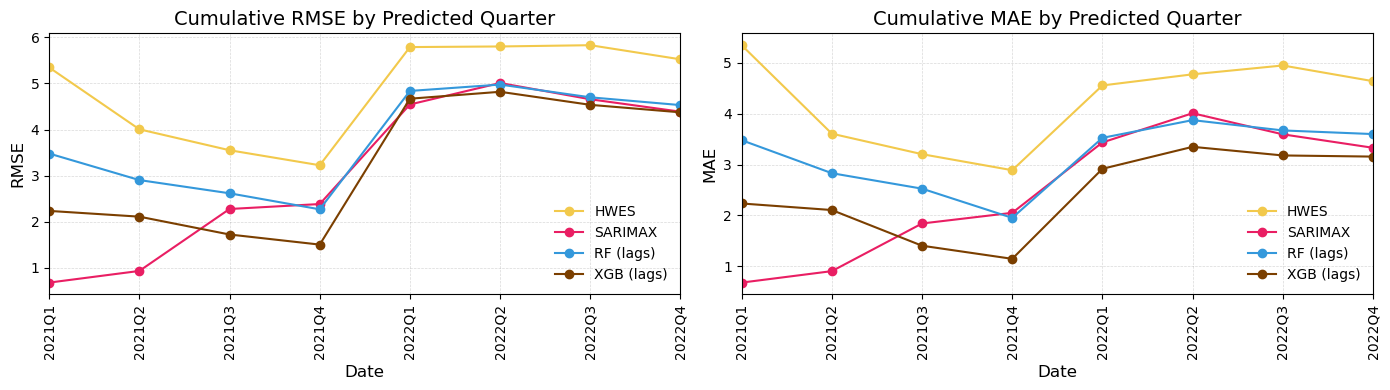

        Model      RMSE       MAE
0        HWES  5.524030  4.640361
1     SARIMAX  4.387729  3.330408
2   RF (lags)  4.530796  3.600143
3  XGB (lags)  4.374013  3.157178


In [18]:
metrics = evaluate_and_plot_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    n_test=8,
    seasonal_m=4,
    lags=[1,4]
)
print(metrics)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Model Evaluation on Multivariate Time series
  </h5>
</div>

Multivariate forecasting lets us incorporate additional features (exogenous features, e.g. weather, diseases) into models. However, when we roll our model forward to make predictions, we typically no longer have “future” values of those features. To address this, we derive lagged versions of every input (target and exogenous) from the historical data (e.g. t-1, t-4, etc.). We will train Random Forest and XGBoost models on those lagged features and when forecasting, we again supply just those same lagged values. This ensures our predictions rely solely on information that would actually have been available at forecast time.

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis
  </h7>
</div>

In [19]:
state_bees.columns

Index(['state', 'latitude', 'longitude', 'quarter', 'temperature_2m_mean',
       'temperature_2m_sum', 'relative_humidity_2m_mean',
       'relative_humidity_2m_sum', 'wind_speed_10m_max', 'temperature_2m_max',
       'relative_humidity_2m_max', 'temperature_2m_min',
       'relative_humidity_2m_min', 'precipitation_hours_sum',
       'moderate_drizzle_sum', 'moderate_rain_sum', 'light_rain_sum',
       'heavy_rain_sum', 'overcast_sum', 'partly_cloudy_sum', 'clear_sky_sum',
       'light_drizzle_sum', 'mainly_clear_sum', 'heavy_drizzle_sum',
       'light_snow_sum', 'heavy_snow_sum', 'moderate_snow_sum', 'year',
       'D0_mean', 'D1_mean', 'D2_mean', 'D3_mean', 'D4_mean', 'D0_max',
       'D1_max', 'D2_max', 'D3_max', 'D4_max', 'num_colonies', 'max_colonies',
       'lost_colonies', 'percent_lost', 'added_colonies', 'renovated_colonies',
       'percent_renovated', 'varroa_mites', 'other_pests_and_parasites',
       'diseases', 'pesticides', 'other_or_unknown', 'date',
       'percen

In [ ]:
def compare_multivariate_models(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Fit and compare multivariate forecasting models on one target series.

    This function trains and evaluates four static models:
      1. SARIMAX(1,1,1)x(1,1,1,seasonal_m) with exogenous covariates
      2. VAR (vector autoregression) on target + exogenous series
      3. Random Forest using lagged features of target + exogenous series
      4. XGBoost using lagged features of target + exogenous series

    For each model, the final `n_test` observations are held out and
    used to compute RMSE and MAE. It also plots the full actual series
    plus each model’s n_test-step forecast, marking the train/test split.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime column, the target series, and exogenous columns.
    date_col : str
        Name of the datetime column.
    target_col : str
        Name of the series to forecast.
    exog_cols : list[str]
        Names of the exogenous covariate columns.
    n_test : int, default=8
        Number of periods to reserve at the end for testing.
    seasonal_m : int, default=4
        Seasonal period (e.g., 4 for quarterly data).
    lags : list[int], default=[1, 4]
        List of lags to generate features for the ML models.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
          - Model: name of the forecasting model
          - RMSE: root mean squared error on the test set
          - MAE: mean absolute error on the test set
    Displays a matplotlib plot of actual vs. forecasted values for all models.

    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    y_full  = df[target_col]
    exog    = df[exog_cols]
    train_y = y_full.iloc[:-n_test]
    test_y  = y_full.iloc[-n_test:]
    train_ex = exog.iloc[:-n_test]
    test_ex  = exog.iloc[-n_test:]

    # 1) SARIMAX
    sarimax = SARIMAX(
        train_y,
        exog=train_ex,
        order=(1,1,1),
        seasonal_order=(1,1,1, seasonal_m),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    sarimax_preds = pd.Series(
        sarimax.predict(start=test_y.index[0],
                        end=test_y.index[-1],
                        exog=test_ex),
        index=test_y.index
    )

    # 2) VAR on [target + exog]
    df_var    = pd.concat([y_full, exog], axis=1)
    train_var = df_var.iloc[:-n_test]
    test_var  = df_var.iloc[-n_test:]
    var_model = VAR(train_var)
    try:
        var_fit = var_model.fit(ic='aic', maxlags=seasonal_m)
    except ValueError:
        k, N = train_var.shape[1], train_var.shape[0]
        safe_max = max(1, N // (k * 5))
        var_fit = var_model.fit(maxlags=safe_max)
    var_fc = var_fit.forecast(train_var.values[-var_fit.k_ar:], steps=n_test)
    var_preds = pd.Series(
        var_fc[:, df_var.columns.get_loc(target_col)],
        index=test_y.index
    )

    # 3) Random Forest with lag features
    df_ml = pd.concat([y_full.rename('y'), exog], axis=1)
    for col in df_ml.columns:
        for lag in lags:
            df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
    df_ml.dropna(inplace=True)
    ml_train = df_ml.iloc[:-n_test]
    ml_test  = df_ml.iloc[-n_test:]
    X_train, y_train = ml_train.drop(columns=['y']), ml_train['y']
    X_test,  y_test  = ml_test.drop(columns=['y']), ml_test['y']

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = pd.Series(rf.predict(X_test), index=y_test.index)

    # 4) XGBoost with lag features
    xgb = XGBRegressor(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='rmse'
    )
    xgb.fit(X_train, y_train)
    xgb_preds = pd.Series(xgb.predict(X_test), index=y_test.index)

    # Compute metrics
    def compute_metrics(y_true, y_pred):
        mask = (~y_true.isna()) & (~y_pred.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_true[mask], y_pred[mask])),
            mean_absolute_error(y_true[mask], y_pred[mask])
        )

    metrics = pd.DataFrame([
        ('SARIMAX',    *compute_metrics(test_y, sarimax_preds)),
        ('VAR',        *compute_metrics(test_y, var_preds)),
        ('RF (lags)',  *compute_metrics(y_test, rf_preds)),
        ('XGB (lags)', *compute_metrics(y_test, xgb_preds))
    ], columns=['Model', 'RMSE', 'MAE'])

    # Plot actual vs forecasts
    df_fore = pd.DataFrame({
        'SARIMAX':    sarimax_preds,
        'VAR':        var_preds,
        'RF (lags)':  rf_preds,
        'XGB (lags)': xgb_preds
    })
    df_plot = pd.concat([y_full.rename('Actual'), df_fore], axis=1)

    fig, ax = plt.subplots(figsize=(12, 6))
    df_plot['Actual'].plot(ax=ax, lw=2, color='black', label='Actual')
    df_plot[['SARIMAX','VAR','RF (lags)','XGB (lags)']].plot(
        ax=ax, linestyle='--', marker='o', alpha=0.8
    )
    split_date = train_y.index[-1]
    ax.axvline(split_date, color='gray', linestyle=':', label='Train/Test split')
    ax.set_title('Multivariate Static Forecasts vs. Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    ax.legend()
    ax.grid(True)

    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    return metrics

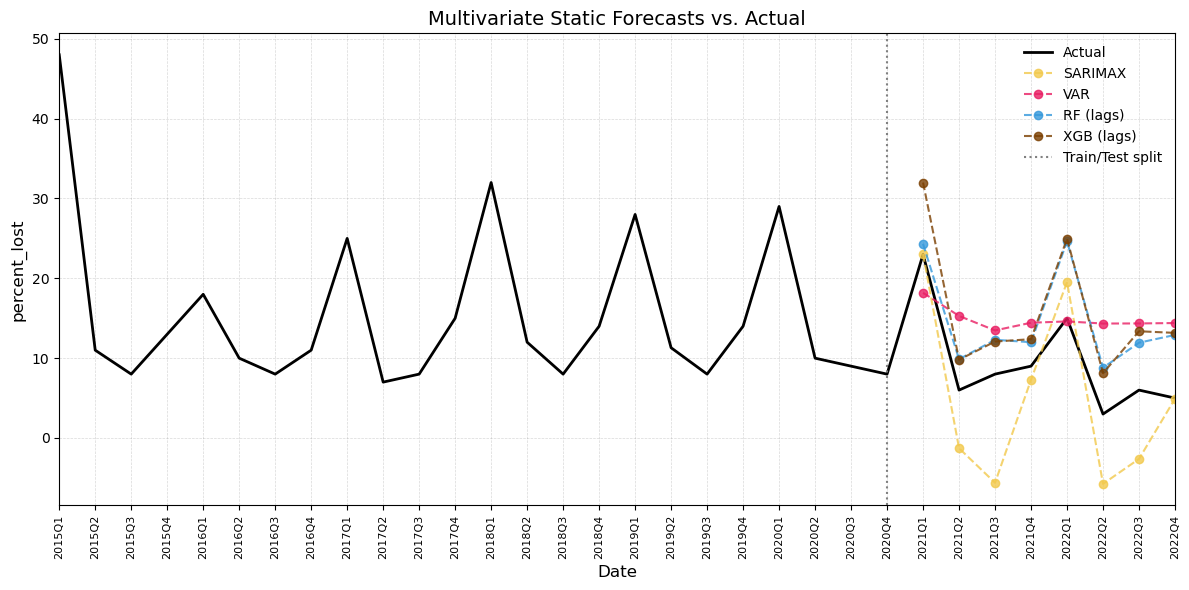

,Model,RMSE,MAE
0,SARIMAX,7.180580,5.574837
1,VAR,7.547799,6.812313
2,RF (lags),5.791592,5.220002
3,XGB (lags),6.801033,6.360681


In [21]:
compare_multivariate_models(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ],
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Static method for multivariate analysis with variable training windows
  </h7>
</div>

In [ ]:
def compare_multivariate_static_windows(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    windows: list[int],
    forecast_horizon: int = 4,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Compare static multi-step forecasts across different training-window sizes.

    For each specified training-window length (in quarters), this function:
      1. Trains four static forecast models on the most recent `window` quarters:
         - SARIMAX(1,1,1)x(1,1,1,seasonal_m) with exogenous regressors
         - VAR on the target plus exogenous series
         - Random Forest on lagged features of the target + exogenous series
         - XGBoost on the same lagged features
      2. Forecasts the next `forecast_horizon` quarters
      3. Computes RMSE and MAE over that horizon
    Finally, it returns a DataFrame of errors and plots RMSE vs. training-window size.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing a date column, the target series, and exogenous columns.
    date_col : str
        Name of the datetime column in `df`.
    target_col : str
        Name of the target series to forecast.
    exog_cols : list[str]
        List of column names in `df` to use as exogenous regressors.
    windows : list[int]
        List of training-window sizes (number of quarters) to evaluate.
    forecast_horizon : int, default=4
        Number of quarters to forecast after each training window.
    seasonal_m : int, default=4
        Seasonal period (e.g., 4 for quarterly data).
    lags : list[int], default=[1, 4]
        List of lag orders to generate features for the Random Forest and XGBoost models.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
          - train_quarters: the size of the training window used
          - Model: one of ['SARIMAX','VAR','RF','XGB']
          - RMSE: root mean squared error over the forecast horizon
          - MAE: mean absolute error over the forecast horizon
    Displays a matplotlib line plot of RMSE vs. training-window size,

    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    series = df[target_col]
    exog   = df[exog_cols]
    N = len(series)

    # Precompute lag-feature DataFrame for ML once
    df_lag = pd.concat([series.rename('y'), exog], axis=1)
    for col in df_lag.columns:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag[col].shift(lag)
    df_lag.dropna(inplace=True)

    results = []

    # iterate window sizes
    for w in windows:
        if w + forecast_horizon > N:
            continue

        # define train/test slices
        train_y = series.iloc[N - forecast_horizon - w : N - forecast_horizon]
        test_y  = series.iloc[N - forecast_horizon : N]
        train_ex = exog.iloc[N - forecast_horizon - w : N - forecast_horizon]
        test_ex  = exog.iloc[N - forecast_horizon : N]
        idx = test_y.index

        # 1) SARIMAX
        try:
            m_sar = SARIMAX(
                train_y,
                order=(1,1,1),
                seasonal_order=(1,1,1, seasonal_m),
                exog=train_ex,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            sar_preds = m_sar.get_forecast(steps=forecast_horizon, exog=test_ex).predicted_mean
        except:
            sar_preds = pd.Series([np.nan]*forecast_horizon, index=idx)
        rmse_sar = np.sqrt(mean_squared_error(test_y, sar_preds))
        mae_sar  = mean_absolute_error(test_y, sar_preds)
        results.append((w, 'SARIMAX', rmse_sar, mae_sar))

        # 2) VAR
        df_var = pd.concat([series, exog], axis=1)
        train_var = df_var.iloc[N - forecast_horizon - w : N - forecast_horizon]
        try:
            var_m = VAR(train_var)
            k, Nt = train_var.shape[1], len(train_var)
            try:
                fit_var = var_m.fit(ic='aic', maxlags=seasonal_m)
            except ValueError:
                safe = max(1, Nt//(k*5))
                fit_var = var_m.fit(maxlags=safe)
            fc = fit_var.forecast(train_var.values[-fit_var.k_ar:], steps=forecast_horizon)
            var_preds = pd.Series(fc[:, df_var.columns.get_loc(target_col)], index=idx)
        except:
            var_preds = pd.Series([np.nan]*forecast_horizon, index=idx)
        rmse_var = np.sqrt(mean_squared_error(test_y, var_preds))
        mae_var  = mean_absolute_error(test_y, var_preds)
        results.append((w, 'VAR', rmse_var, mae_var))

        # 3) RandomForest on lag features
        train_ml = df_lag.loc[train_y.index.intersection(df_lag.index)]
        test_ml  = df_lag.loc[test_y.index.intersection(df_lag.index)]
        if train_ml.empty or test_ml.empty:
            rmse_rf, mae_rf = np.nan, np.nan
        else:
            X_tr, y_tr = train_ml.drop(columns=['y']), train_ml['y']
            X_te, y_te = test_ml.drop(columns=['y']),  test_ml['y']
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_tr, y_tr)
            rf_preds = pd.Series(rf.predict(X_te), index=test_ml.index)
            rmse_rf = np.sqrt(mean_squared_error(y_te, rf_preds))
            mae_rf  = mean_absolute_error(y_te, rf_preds)
        results.append((w, 'RF', rmse_rf, mae_rf))

        # 4) XGBoost on lag features
        if train_ml.empty or test_ml.empty:
            rmse_xgb, mae_xgb = np.nan, np.nan
        else:
            xgb = XGBRegressor(
                n_estimators=100, random_state=42,
                use_label_encoder=False, eval_metric='rmse'
            )
            xgb.fit(X_tr, y_tr)
            xgb_preds = pd.Series(xgb.predict(X_te), index=test_ml.index)
            rmse_xgb = np.sqrt(mean_squared_error(y_te, xgb_preds))
            mae_xgb  = mean_absolute_error(y_te, xgb_preds)
        results.append((w, 'XGB', rmse_xgb, mae_xgb))


    metrics_df = pd.DataFrame(results, columns=['train_quarters','Model','RMSE','MAE'])

    # plot RMSE vs window
    rmse_piv = metrics_df.pivot(index='train_quarters', columns='Model', values='RMSE')
    rmse_piv.plot(marker='o', figsize=(8,5))
    plt.title(f'RMSE vs Training Window (h={forecast_horizon})')
    plt.xlabel('Training Window (quarters)')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics_df

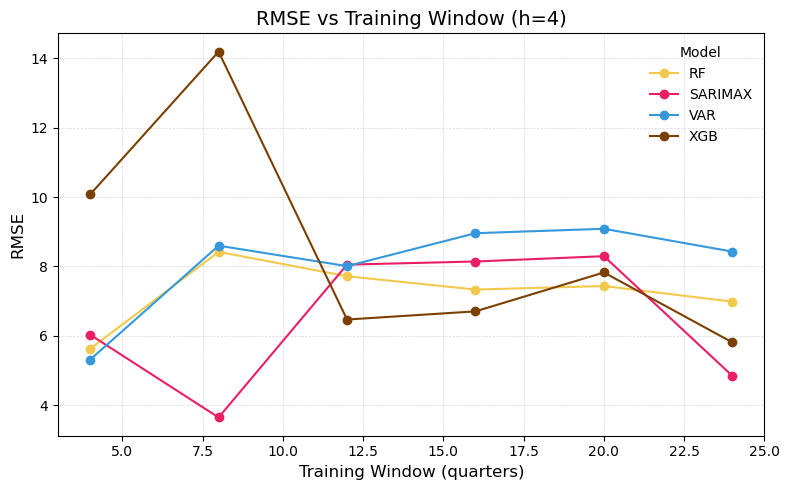

,train_quarters,Model,RMSE,MAE
0,4,SARIMAX,6.030018,5.583333
1,4,VAR,5.309709,3.840950
2,4,RF,5.623638,5.075000
3,4,XGB,10.074197,7.999885
4,8,SARIMAX,3.644405,3.265416
5,8,VAR,8.597444,6.609711
6,8,RF,8.419286,7.957500
7,8,XGB,14.194238,11.499388
8,12,SARIMAX,8.051280,6.994308
9,12,VAR,8.007986,7.791945


In [23]:
compare_multivariate_static_windows(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=['varroa_mites','other_pests_and_parasites','diseases','pesticides','other_or_unknown'],
    windows=[4,8,12,16,20,24],
    forecast_horizon=4,
    seasonal_m=4,
    lags=[1,4]
)

<div
  style="
    background-color: #fffad5;
    color: black;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h7 style="margin: 0; display: inline-block; vertical-align: middle;">
    Walk-forward method for multivariate analysis
  </h7>
</div>

In [ ]:
def compare_multivariate_walkforward(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    exog_cols: list[str],
    n_test: int = 8,
    seasonal_m: int = 4,
    lags: list[int] = [1, 4]
) -> pd.DataFrame:
    """
    Perform one-step walk-forward forecasting with multiple multivariate models.

    At each of the final `n_test` periods, this function:
      1. Fits a SARIMAX(1,1,1)x(1,1,1,seasonal_m) model with exogenous covariates
      2. Fits a VAR model on the target plus exogenous series
      3. Fits a RandomForest on lagged features of target + exogenous
      4. Fits an XGBoost on the same lagged features
    It then forecasts the next step, appends the observed value to history,
    and repeats until all `n_test` points are predicted.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least one datetime column, the target series,
        and the specified exogenous columns.
    date_col : str
        Name of the datetime column to set as index.
    target_col : str
        Name of the series to forecast.
    exog_cols : list[str]
        List of column names in `df` to use as exogenous regressors.
    n_test : int, default=8
        Number of periods at the end reserved for walk-forward testing.
    seasonal_m : int, default=4
        Seasonal period (e.g., 4 for quarterly data).
    lags : list[int], default=[1, 4]
        Lag orders used to generate features for the RandomForest and XGBoost models.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['Model','RMSE','MAE'], giving overall
        root mean squared error and mean absolute error on the test set
        for each model: ['SARIMAX','VAR','RF (lags)','XGB (lags)'].
    Displays a line plot of forecasts vs. actual values (with quarterly ticks).
    Displays side-by-side plots of cumulative RMSE and MAE by quarter.

    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    train_df = df.iloc[:-n_test]
    test_df  = df.iloc[-n_test:]
    history  = train_df.copy()
    idx_test = test_df.index

    preds = { 'SARIMAX': [], 'VAR': [], 'RF (lags)': [], 'XGB (lags)': [] }

    for t in range(n_test):
        # 1) SARIMAX
        y_hist  = history[target_col]
        ex_hist = history[exog_cols]
        try:
            m_sar = SARIMAX(
                y_hist,
                exog=ex_hist,
                order=(1,1,1),
                seasonal_order=(1,1,1, seasonal_m),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            ex_next = test_df[exog_cols].iloc[[t]]
            sar_fc = m_sar.get_forecast(steps=1, exog=ex_next).predicted_mean
            preds['SARIMAX'].append(sar_fc.iloc[0])
        except:
            preds['SARIMAX'].append(np.nan)

        # 2) VAR
        df_var = history[[target_col] + exog_cols]
        var_m  = VAR(df_var)
        k, N   = df_var.shape[1], df_var.shape[0]
        try:
            var_f = var_m.fit(ic='aic', maxlags=seasonal_m)
        except ValueError:
            safe = max(1, N // (k * 5))
            var_f = var_m.fit(maxlags=safe)
        fc_var = var_f.forecast(df_var.values[-var_f.k_ar:], steps=1)[0]
        idx_tar = df_var.columns.get_loc(target_col)
        preds['VAR'].append(fc_var[idx_tar])

        # 3+4) ML on lags
        df_ml = history[[target_col] + exog_cols].copy()
        for col in [target_col] + exog_cols:
            for lag in lags:
                df_ml[f'{col}_lag_{lag}'] = df_ml[col].shift(lag)
        df_ml.dropna(inplace=True)
        X_ml, y_ml = df_ml.drop(columns=[target_col]), df_ml[target_col]

        # build next-step features: contemporaneous exogs + all lags
        feat = {col: test_df[col].iloc[t] for col in exog_cols}
        for col in [target_col] + exog_cols:
            for lag in lags:
                feat[f'{col}_lag_{lag}'] = history[col].iloc[-lag]

        # RandomForest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_ml, y_ml)
        preds['RF (lags)'].append(rf.predict(pd.DataFrame([feat]))[0])

        # XGBoost
        xgb = XGBRegressor(
            n_estimators=100, random_state=42,
            use_label_encoder=False, eval_metric='rmse'
        )
        xgb.fit(X_ml, y_ml)
        preds['XGB (lags)'].append(xgb.predict(pd.DataFrame([feat]))[0])

        # reveal next actual
        history = pd.concat([history, test_df.iloc[[t]]])

    # --- Build Series & compute overall metrics ---
    s_true = test_df[target_col]
    s_pred = {
        name: pd.Series(vals, index=idx_test, name=name)
        for name, vals in preds.items()
    }

    def score(y_t, y_p):
        mask = (~y_t.isna()) & (~y_p.isna())
        if not mask.any():
            return np.nan, np.nan
        return (
            np.sqrt(mean_squared_error(y_t[mask], y_p[mask])),
            mean_absolute_error(y_t[mask], y_p[mask])
        )

    metrics = pd.DataFrame([
        (name, *score(s_true, s_pred[name]))
        for name in s_pred
    ], columns=['Model','RMSE','MAE'])

    # --- Plot 1: forecasts vs. actual with quarterly x-tick formatting ---
    df_plot = pd.concat([s_true.rename('Actual')] + list(s_pred.values()), axis=1)

    fig, ax = plt.subplots(figsize=(12, 4))
    df_plot.plot(marker='o', ax=ax)
    ax.axvline(idx_test[0], color='gray', linestyle='--', label='Start Test')
    ax.set_title('One-Step Walk-Forward Forecasts vs Actual')
    ax.set_xlabel('Date')
    ax.set_ylabel(target_col)
    quarters = [f"{d.year}Q{d.quarter}" for d in df_plot.index]
    ax.set_xticks(df_plot.index)
    ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
    ax.legend()
    ax.grid(True)

    # --- Plot 2: cumulative RMSE & MAE by quarter ---
    errors = {name: s_pred[name].values - s_true.values for name in s_pred}
    ks = np.arange(1, n_test+1)
    cum_rmse = pd.DataFrame(
        {name: [np.sqrt((errors[name][:k]**2).mean()) for k in ks] for name in errors},
        index=idx_test
    )
    cum_mae = pd.DataFrame(
        {name: [np.abs(errors[name][:k]).mean() for k in ks] for name in errors},
        index=idx_test
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
    cum_rmse.plot(ax=ax1, marker='o'); ax1.set_title('RMSE by Predicted Quarter')
    ax1.set_xlabel('Date'); ax1.set_ylabel('RMSE')
    cum_mae.plot(ax=ax2, marker='o'); ax2.set_title('MAE by Predicted Quarter')
    ax2.set_xlabel('Date'); ax2.set_ylabel('MAE')
    for ax in (ax1, ax2):
        ax.set_xticks(idx_test)
        ax.set_xticklabels(quarters, rotation=90, ha='center', fontsize=8)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return metrics

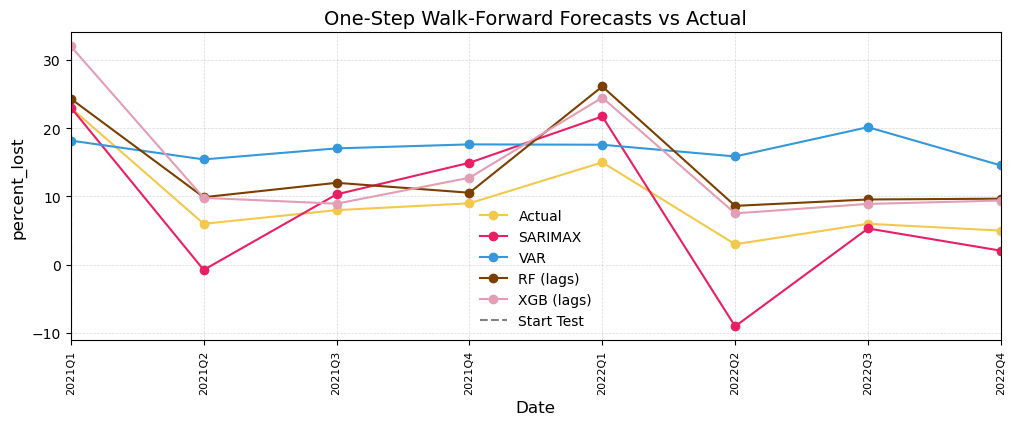

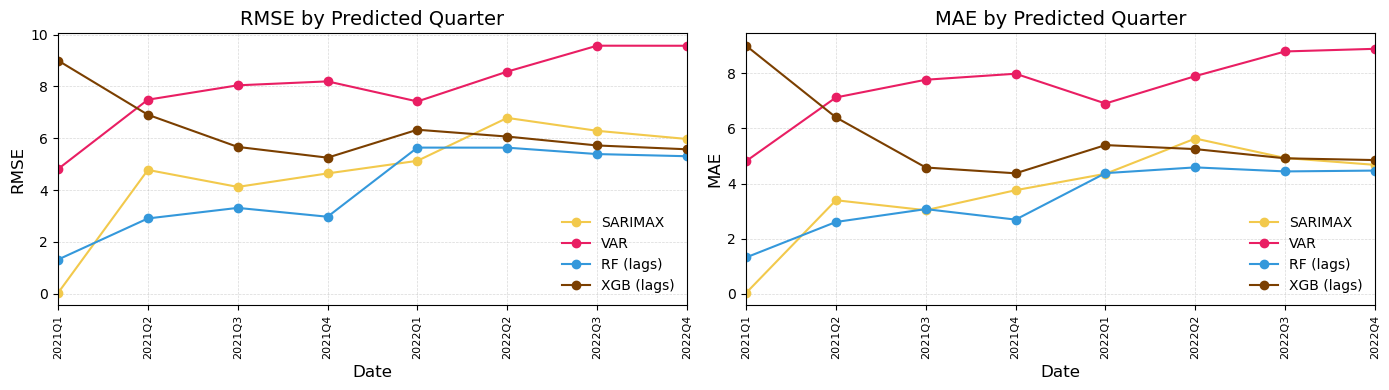

,Model,RMSE,MAE
0,SARIMAX,5.972151,4.677701
1,VAR,9.567674,8.885230
2,RF (lags),5.306259,4.469730
3,XGB (lags),5.574291,4.851121


In [25]:
compare_multivariate_walkforward(
    df=state_bees,
    date_col='date',
    target_col='percent_lost',
    exog_cols=[
        'varroa_mites', 'other_pests_and_parasites', 'diseases', 'pesticides',
        'other_or_unknown'
    ],  # adjust features of interest as needed
    n_test=8,
    seasonal_m=4,
    lags=[1, 4]
)

<div
  style="
    background-color: #985b10;
    color: white;
    font-weight: bold;
    height: 50px;
    line-height: 50px;
    border-radius: 5px;
    padding: 0 10px;
  "
>
  <h5 style="margin: 0; display: inline-block; vertical-align: middle;">
    Multiple states example for a particular prediction
  </h5>
</div>

Results for California


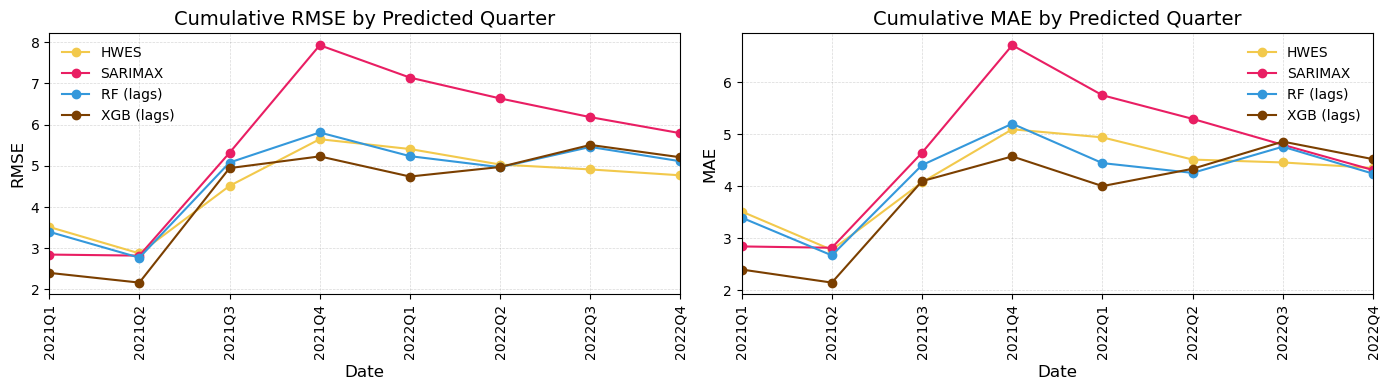


========== California ==========
        Model      RMSE       MAE
0        HWES  4.770416  4.354296
1     SARIMAX  5.792771  4.315119
2   RF (lags)  5.111594  4.244963
3  XGB (lags)  5.208749  4.523840


Results for Texas


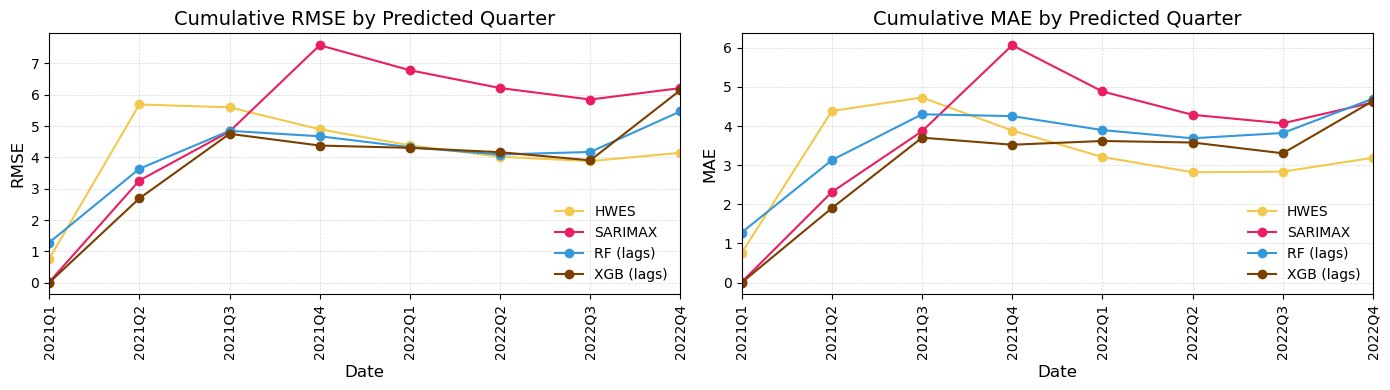


========== Texas ==========
        Model      RMSE       MAE
0        HWES  4.147007  3.188424
1     SARIMAX  6.214249  4.602755
2   RF (lags)  5.471494  4.699224
3  XGB (lags)  6.152218  4.640360


Results for Florida


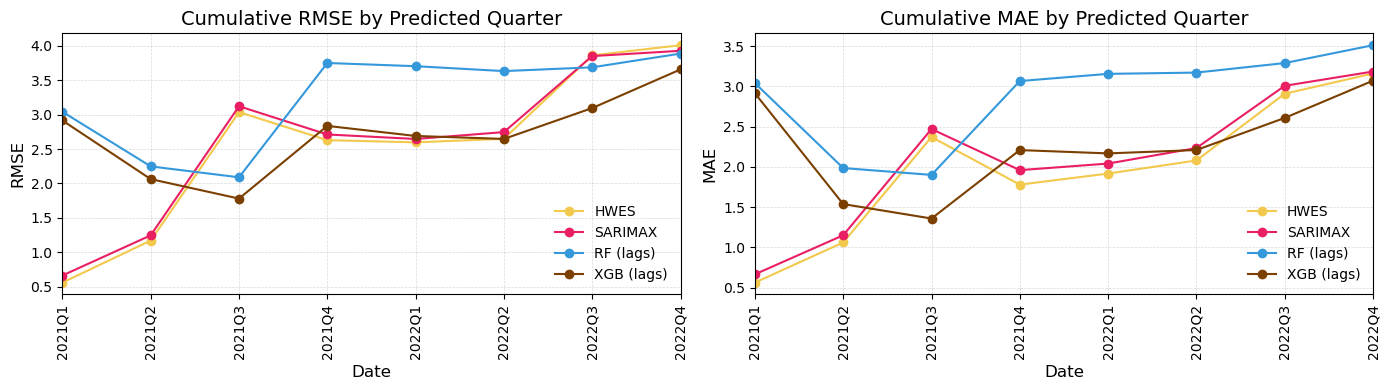


========== Florida ==========
        Model      RMSE       MAE
0        HWES  4.005146  3.158642
1     SARIMAX  3.924157  3.183407
2   RF (lags)  3.883602  3.510352
3  XGB (lags)  3.653556  3.070014



Overall Summary
         Model      RMSE       MAE       state
0         HWES  4.770416  4.354296  California
1      SARIMAX  5.792771  4.315119  California
2    RF (lags)  5.111594  4.244963  California
3   XGB (lags)  5.208749  4.523840  California
4         HWES  4.147007  3.188424       Texas
5      SARIMAX  6.214249  4.602755       Texas
6    RF (lags)  5.471494  4.699224       Texas
7   XGB (lags)  6.152218  4.640360       Texas
8         HWES  4.005146  3.158642     Florida
9      SARIMAX  3.924157  3.183407     Florida
10   RF (lags)  3.883602  3.510352     Florida
11  XGB (lags)  3.653556  3.070014     Florida


In [26]:
# input states of interest to run (more states means longer run time)
states = ['California', 'Texas', 'Florida'] 
n_test = 8
lags   = [1, 4]

all_metrics = []
for st in states:
    print(f'Results for {st}')
    # Filter from the full bees DataFrame
    df_st = bees[bees['state'] == st].copy()
    
    # Make sure there’s enough historical data
    total_q   = len(df_st)
    min_needed = n_test + max(lags) + 1
    if total_q < min_needed:
        print(f"Skipping {st}: only {total_q} quarters (need ≥ {min_needed})")
        continue
    
# Functions available to use:
# univariate static: compare_univariate_static
# univariate walk-forward: evaluate_and_plot_walkforward
# multivariate static: compare_multivariate_models
# multivariate static adjustable window size: compare_multivariate_static_windows
# multivariate walk-forward: compare_multivariate_walkforward


    try: # input model of interest!
        metrics = evaluate_and_plot_walkforward(
            df=df_st,
            date_col='date',
            target_col='percent_lost',
            n_test=8,
            seasonal_m=4,
            lags=[1,4]
            )

    except ValueError as e:
        print(f"Error for {st}: {e}")
        continue

    # Print a header for this state, then its metrics
    print("\n" + "="*10 + f" {st} " + "="*10)
    print(metrics)
    print("\n" + "="*175)
    print("\n" + "="*175)
    # keep for later aggregation if you want
    metrics = metrics.copy()
    metrics['state'] = st
    all_metrics.append(metrics)


if all_metrics:
    summary = pd.concat(all_metrics, ignore_index=True)
    print("\n" + "="*30)
    print("Overall Summary")
    print("="*30)
    print(summary)